<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/Method_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
import numpy as np
import pylab
import pandas
import sys
from PIL import Image

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    HOME_DIR = "/content"
else:
    HOME_DIR = "/arc/project/st-dushan20-1/rendered"

In [3]:
sys.path.append(f"{HOME_DIR}/IUPAC2Struct")

In [ ]:
!git clone https://github.com/sergsb/IUPAC2Struct.git

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

if IN_COLAB:
    os.system('cp drive/MyDrive/WWVSB/iupac2smiles_model.pt .')

M = torch.load(f"{HOME_DIR}/iupac2smiles_model.pt", map_location=device)
M.device = device

In [21]:
def subsequent_mask(tgt_mask):
    size = tgt_mask.size(-1)
    return tgt_mask.to(torch.uint8) & torch.tril(torch.ones(1,size,size, dtype=torch.uint8)).to(tgt_mask.device)

def pad_pack(sequences):
    maxlen = 200#max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch

(200, 512)


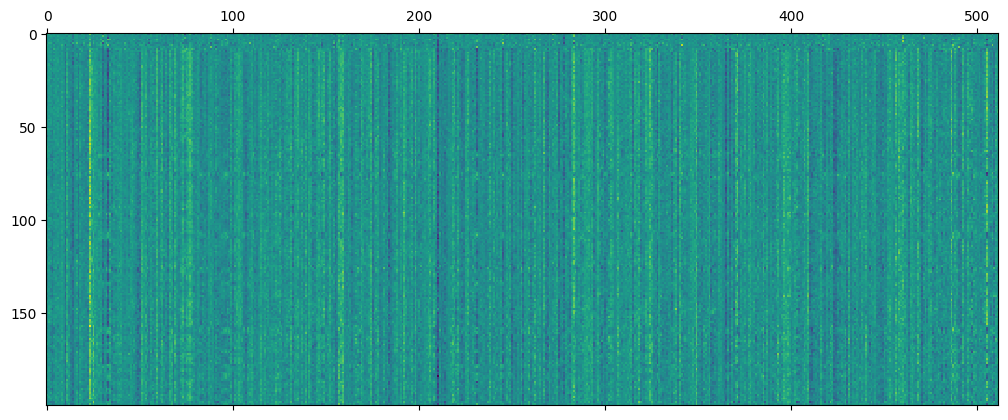

In [22]:
inp = M.src_model.encode("N-(4-hydroxyphenyl)acetamide")
src = pad_pack([inp])
src_mask = (src != 0).unsqueeze(-2).to(M.device)
latent = M.T.encoder(M.T.src_embedder(src), (src != 0).unsqueeze(-2).to(M.device))
l = latent.to(torch.device("cpu"))
pylab.matshow(l.cpu().detach().numpy()[0])
print(l.cpu().detach().numpy()[0].shape)

In [23]:
os.system("wget http://file.weasoft.com/80k.csv")

0

In [25]:
import pandas as pd
csv = pd.read_csv("80k.csv")
cids = csv["cid"]
csv.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [82]:
batch_size = 512
iupacs = np.array(csv["iupacname"])

In [47]:
max_len = max([len(i) for i in iupacs])

(array([1.4360e+03, 1.4065e+04, 3.1914e+04, 2.0227e+04, 8.0910e+03,
        2.6210e+03, 5.9300e+02, 1.4900e+02, 3.3000e+01, 1.0000e+01]),
 array([  4. ,  14.4,  24.8,  35.2,  45.6,  56. ,  66.4,  76.8,  87.2,
         97.6, 108. ]),
 <BarContainer object of 10 artists>)

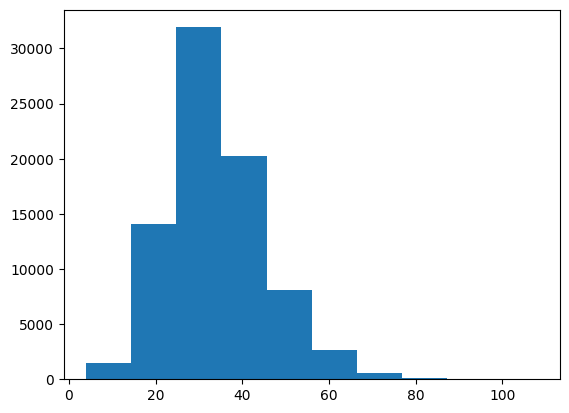

In [89]:
pylab.hist([len(i) for i in iupacs if type(i)==str])

In [49]:
def pad_pack(sequences):
    maxlen = max_len#max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch

In [54]:
iupacs_ = iupacs[:len(iupacs)//512*512]

In [55]:
left_over = iupacs[len(iupacs_):]

In [56]:
iupacs = np.split(iupacs_, batch_size)

In [71]:
invalid = []
def get_latent(IUPACs_):
  IUPACs = []
  for i in IUPACs_:
    try:
      t = M.src_model.encode(i)
      assert t
      IUPACs.append(t)
    except:
      invalid.append(i)
  src = pad_pack(IUPACs)
  src_mask = (src != 0).unsqueeze(-2).to(M.device)
  latent = M.T.encoder(M.T.src_embedder(src), src_mask)
  l = latent.to(torch.device("cpu"))
  print(l.cpu().detach().numpy()[0].shape)
  return l

In [73]:
for i in iupacs:
  get_latent(i)

(155, 512)


tensor([[[-0.0309, -0.0132,  0.0520,  ...,  0.0414,  0.0594,  0.0337],
         [ 0.0079, -0.0074,  0.0226,  ...,  0.0260, -0.0440,  0.0088],
         [-0.0023, -0.0011, -0.0136,  ..., -0.0439, -0.0916,  0.0401],
         ...,
         [ 0.0416,  0.0210,  0.0648,  ..., -0.0817, -0.0787,  0.0335],
         [ 0.0760, -0.0076,  0.1075,  ..., -0.0945, -0.0271,  0.0041],
         [ 0.0327,  0.0127,  0.0477,  ..., -0.0878, -0.0604,  0.0080]],

        [[ 0.0187, -0.0183, -0.0027,  ...,  0.0275,  0.0022,  0.0031],
         [ 0.1090,  0.0036,  0.0355,  ...,  0.0538, -0.0653,  0.0860],
         [ 0.0694,  0.0121,  0.0168,  ..., -0.0303,  0.0125,  0.0257],
         ...,
         [ 0.0790, -0.0276,  0.0043,  ...,  0.1210,  0.0500,  0.0206],
         [ 0.0457,  0.0385, -0.0558,  ...,  0.0892,  0.0814, -0.0053],
         [ 0.0436,  0.0311, -0.1283,  ...,  0.0610,  0.0656, -0.0092]],

        [[ 0.0327,  0.0633, -0.0285,  ...,  0.0463,  0.0502, -0.0677],
         [ 0.0051,  0.0822, -0.0261,  ..., -0

In [78]:
pylab.matshow(_.detach().numpy()[10])

AttributeError: ignored